In [1]:
%cd '~/marker_identification/'
import sys
import os
module_path  = os.path.abspath("./scripts/")
sys.path.append(module_path)

/work/jmainguy/marker_identification


In [2]:
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt, ceil
import matplotlib.gridspec as gridspec
import logging
import graph_display
import plotly.graph_objects as go
import tools
from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, TextFace
import graph_display
import re

In [3]:
import blast_analysis_fct

In [4]:
cov_threshold = 90
pident_threshold = 90
outfmt = 'qseqid qstart qend qlen sseqid sstart send slen length pident qcovhsp qcovs evalue bitscore'.split(' ')

region = "COG0087-COG0186"

preprocess_result = f'descrimination_evaluation/all_regions_analysis/preprocessed_blast_results/preprocessed_{region}_blast_result.tsv'
G = blast_analysis_fct.get_graph_from_blast_result(preprocess_result, cov_threshold, pident_threshold, outfmt)

#blast_analysis_fct.nx_graph_to_tsv(G_COG0087_186, 'COG0092-COG0197_vs_COG0087-COG0186/G_COG0087_186.tsv')
#blast_analysis_fct.nx_graph_to_tsv(G_COG0092_197, 'COG0092-COG0197_vs_COG0087-COG0186/G_COG0092_197.tsv')

In [5]:
len(set(nx.nodes(G)))

5381

In [5]:
# Get info from genome of the sequences in sub_graph 
selected_assemblies_fl = 'descrimination_evaluation/genome_taxonomy/selected_assemblies.tsv'
assembly_dict = tools.tsv_to_dict_of_dicts(selected_assemblies_fl, "assembly_accession")

#preprocess file with only taxid under study
ranked_linage_file = "descrimination_evaluation/genome_taxonomy/selected_taxids_ranked.txt"
taxid_ranked = blast_analysis_fct.get_taxid_ranked_lineage(ranked_linage_file)

node_to_lineage_dict = blast_analysis_fct.get_node_to_lineage_dict(nx.nodes(G),taxid_ranked, assembly_dict)
print(f'GPD of {region}', blast_analysis_fct.get_global_phylo_div(G, node_to_lineage_dict))


trees = blast_analysis_fct.get_trees_from_graph(G, node_to_lineage_dict)



GPD of COG0052-COG0264 3.038791495710556


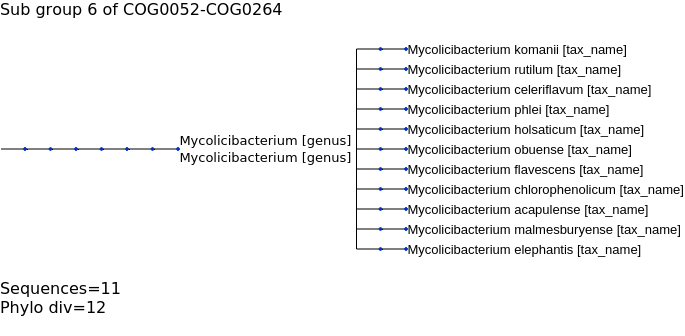

In [6]:
def get_style_sub_group_tree(tree):
    
    phylod = blast_analysis_fct.get_phylo_div(t)

    ts = TreeStyle()
    ts.show_leaf_name = True
    ts.legend_position = 3
    ts.show_scale = False
    ts.branch_vertical_margin = 5
    textface_title = TextFace(f"Sub group {tree_number} of {region}\n", fsize=12)
    ts.title.add_face(textface_title, column=0)

    textface_legend = TextFace(f"\nSequences={len(t)}\nPhylo div={phylod}\n", fsize=12)
    ts.legend.add_face(textface_legend, column=0)
    
    

    lca = blast_analysis_fct.get_lca_tree(tree)
    tface = TextFace(lca.name)
    tface.margin_right = 5
    lca.add_face(tface, column=-1)


    return ts

tree_number = 6

t = trees[tree_number]
ts = get_style_sub_group_tree(t)

tree_img = t.render("%%inline", tree_style=get_style_sub_group_tree(t))
display(tree_img)



In [7]:
def get_in_between_elements(gff_file, gene1, gene2):
    generator = parse_gff_file(gff_file)
    
    #print(gene1)
    in_between_flag = False
    in_between_lines = []
    
    #find the first gene 
    for f in generator:
        if f['type'] == 'CDS' and f['attributes']['Name'] ==  gene1:
            gene1_line = f
            in_between_lines.append(f)
            in_between_flag = True
            continue
        if f['type'] == 'CDS' and f['attributes']['Name'] == gene2:
            gene2_line = f
            in_between_lines.append(f)
            break
        if in_between_flag and f['type'] != 'gene':
            in_between_lines.append(f)
    return in_between_lines

def parse_gff_file(file):
    # parse file
    headers = ["seqid",  # name of the chromosome or scaffold; chromosome names can be given with or without the 'chr' prefix. Important note: the seq ID must be one used within Ensembl, i.e. a standard chromosome name or an Ensembl identifier such as a scaffold ID, without any additional content such as species or assembly. See the example GFF output below.
                 # name of the program that generated this feature, or the data source (database or project name)
                 "source",
                 "type",  # type of feature. Must be a term or accession from the SOFA sequence ontology
                 # Start position of the feature, with sequence numbering starting at 1.
                 "start",
                 "end",  # End position of the feature, with sequence numbering starting at 1.
                 "score",  # A floating point value.
                 "strand",  # defined as + (forward) or", # (reverse).
                 "phase",  # One of '0', '1' or '2'. '0' indicates that the first base of the feature is the first base of a codon, '1' that the second base is the first base of a codon, and so on..
                 "attributes",  # A semicolon#separated list of tag#value pairs, providing additional information about each feature. Some of these tags are predefined, e.g. ID, Name, Alias, Parent", # see the GFF documentation for more details.
                 ]
    proper_open = gzip.open if file.endswith('.gz') else open
    
    with proper_open(file, 'rt') as gff_file:
        
        for l in gff_file:
            #print(l)
            if l.startswith('#'):
                continue
            l = l.strip()
            dict_line =  {k:v for k, v in zip(headers, l.split('\t'))}
            attributes = defaultdict(lambda: None)
            for kv in dict_line['attributes'].split(';'):
                try:
                    k, v = kv.split('=')
                    attributes[k] = v
                except ValueError:
                    pass
            dict_line['attributes'] = attributes
            yield dict_line

In [8]:

pair_distance_file_dir = "nextflow_result_2/cog_pairs/"

assemblies_dir = "ncbi_data/assemblies_flat/"

cog_pair_file = os.path.join(pair_distance_file_dir, region + ".tsv")

pair_infos = tools.tsv_to_list_of_dict(cog_pair_file)
print(pair_infos)

#get_in_between_elements(gff_file, gene1, gene2)


[OrderedDict([('cog_pair', 'COG0264|COG0052'), ('genes', 'WP_015199169.1|WP_015199168.1'), ('strands', '+|+'), ('positions', '4304214-4305158|4303261-4304043'), ('distance', '6767664'), ('genome', 'GCF_000317435.1_ASM31743v1'), ('seqid', 'NC_019751.1')]), OrderedDict([('cog_pair', 'COG0052|COG0264'), ('genes', 'WP_015199168.1|WP_015199169.1'), ('strands', '+|+'), ('positions', '4303261-4304043|4304214-4305158'), ('distance', '1898'), ('genome', 'GCF_000317435.1_ASM31743v1'), ('seqid', 'NC_019751.1')]), OrderedDict([('cog_pair', 'COG0264|COG0052'), ('genes', 'WP_090668632.1|WP_090668634.1'), ('strands', '-|-'), ('positions', '171912-172562|172657-173355'), ('distance', '1444'), ('genome', 'GCF_900100345.1_IMG-taxon_2617270934_annotated_assembly'), ('seqid', 'NZ_FMTT01000006.1')]), OrderedDict([('cog_pair', 'COG0052|COG0264'), ('genes', 'WP_040302429.1|WP_043065956.1'), ('strands', '+|+'), ('positions', '1714384-1715094|1715215-1716102'), ('distance', '1719'), ('genome', 'GCF_001274715.1